# 3. Implementación de algoritmos de Machine Learning no supervisados (Spectral Clustering)

En la sección anterior, implementamos y probamos K-means, encontrando que este algoritmo es efectivo principalmente para agrupar datos cuando los grupos tienen formas relativamente simples. Sin embargo, su efectividad se ve limitada cuando los grupos presentan formas muy complejas, debido al uso de la distancia euclidiana para calcular las similitudes entre los centroides y los puntos en el espacio. Por lo tanto, es crucial considerar otros algoritmos para agrupar datos que presenten formas más complejas. Scikit-learn proporciona una buena descripción de cuándo utilizar el clustering espectral (Spectral clustering): este método resulta muy útil cuando la estructura de los grupos individuales es altamente no convexa o cuando la medida de centro y extensión de un grupo no es adecuada para describir el grupo completo. Esto es especialmente relevante en situaciones donde los grupos están anidados o tienen formas como círculos en un plano 2D: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

## 3.1 Implementación del algoritmo con las librerías NumPy y SciPy

En esta sección 3, nos dedicaremos a implementar el algoritmo de Spectral Clustering paso a paso. La palabra "Spectral" hace referencia al uso de valores y vectores propios de una matriz de similitud en algún punto del proceso. Por lo tanto, el primer paso es calcular esta matriz.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#### 1. Generemos un conjunto de datos.

In [2]:
from sklearn.datasets import make_circles

In [3]:
carac_circulos, _ = make_circles(n_samples= 1000, factor=0.5, noise=0.05, random_state=42)

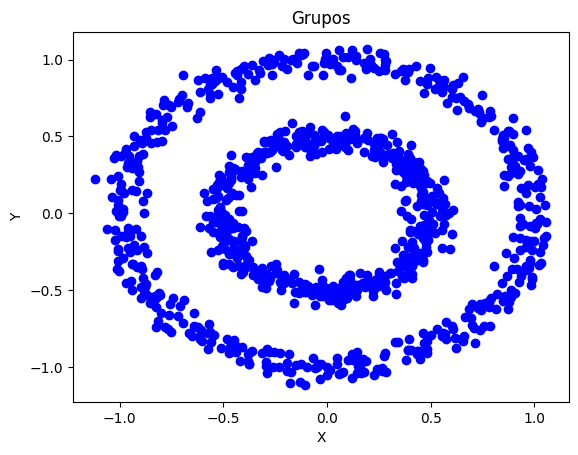

In [4]:
plt.scatter(carac_circulos[:,0], carac_circulos[:,1], c = 'blue')
plt.title('Grupos')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#### 2. Calulamos la matriz de afinidad $A$

$A$ : Matriz de afinidad $\epsilon$ $\mathbb{R}^{n\times n}$

$$A_{ij}=exp\left ( -\frac{\left \| s_{i} - s_{j} \right \|^{2}}{2\sigma ^{2}} \right )$$

if $i \neq j$ and $A_{ii} = 0$

En este punto, la matriz de afinidad se calcula a partir de un kernel de función de base radial (RBF kernel, por sus siglas en inglés). $\left \| s_{i} - s_{j} \right \|^{2}$ representa la distancia euclidiana al cuadrado entre los dos vectores de características. El kernel RBF tiene un parámetro σ que será necesario ajustar para lograr un agrupamiento adecuado de los datos.

In [5]:
sigma = 0.1

distances = sp.spatial.distance.cdist(carac_circulos, carac_circulos, metric='euclidean')

A = np.exp(-np.power(distances,2) / (2 * np.power(sigma, 2)))
np.fill_diagonal(A, 0)

#### 3. Calculamos la matriz diagonal $D^{-\frac{1}{2}}$

$$D_{ii} = \sum_{j} A_{ij}$$

$$D^{-\frac{1}{2}} = \frac{1}{\sqrt{D_{ii}}}$$

La matriz $D^{-\frac{1}{2}}$ nos permitirá realizar una normalización a la matriz $A$ 

In [6]:
D_inv = np.diag(1 / np.sqrt(np.sum(A, axis = 1)))

#### 4. Calculamos la matriz resultante $L$

$$ L = D^{-\frac{1}{2}} A D^{-\frac{1}{2}} $$

In [7]:
L = D_inv @ A @ D_inv

#### 5. Obtenemos los vectores propios de la matriz $L$

El método `eigsh()` permite calcular los vectores propios. Este método requiere dos parámetros: el primero es la matriz a la cual se le calcularán los vectores propios, en este caso $L$, y el segundo es la cantidad de vectores propios que se retornarán. Esta cantidad es importante, ya que depende del número de grupos en que se requiera agrupar nuestro conjunto de datos; es decir, la cantidad de vectores propios a retornar es equivalente a la cantidad de grupos necesarios. En este caso, necesitamos 2 grupos, por lo tanto, debemos retornar 2 vectores propios.

In [8]:
eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(L, 2)

#### 6. Calculamos la matiz $X$

La matriz $X$ es simplemente la matriz de vectores propios retornada en el paso anterior

In [9]:
X = np.copy(eigenvectors)

#### 7. Normalizamos la matriz $X$ obteniendo la matriz $Y$ 

$$ Y_{ij}=\frac{X_{ij}}{\left (\sum_{j}X_{ij}^{2}  \right )^\frac{1}{2}}$$

In [10]:
fact_mat_x = np.sqrt(np.sum(np.power(X, 2),axis = 1)).reshape(len(X),1)

In [11]:
Y = X / fact_mat_x

Lo que obtenemos con la matriz $Y$ es una representación agrupada de los datos en la misma o en otra dimensión, de tal forma que un algoritmo como K-means podrá agruparlos. Grafiquemos los valores de $Y$.

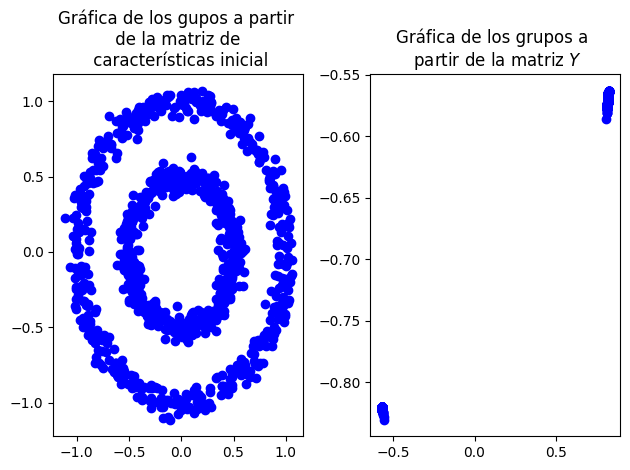

In [12]:
fig, (axes1,axes2) = plt.subplots(nrows=1, ncols=2)
axes1.scatter(carac_circulos[:,0], carac_circulos[:,1], c = 'blue')
axes1.set_title('Gráfica de los gupos a partir \n de la matriz de \n características inicial')

axes2.scatter(Y[:,0], Y[:,1], c = 'blue')
axes2.set_title('Gráfica de los grupos a \n partir de la matriz $Y$')

plt.tight_layout()
plt.show()

#### 8. Aplicamos K-means sobre la matriz $Y$

In [13]:
from sklearn.cluster import KMeans

La cantidad de centroides generados debe ser igual a la cantidad de vectores propios retornados. Para este caso, los centroides generados son 2.

In [14]:
kmeans = KMeans(n_clusters = 2, init='random', max_iter=300)
kmeans.fit(Y)

KMeans(init='random', n_clusters=2)

In [15]:
etiquetas = kmeans.labels_

Para visualizar si los datos fueron agrupados de manera adecuada, basta con graficar la matriz de características utilizando las etiquetas generadas por K-means después de recibir como entrada la matriz $Y$  

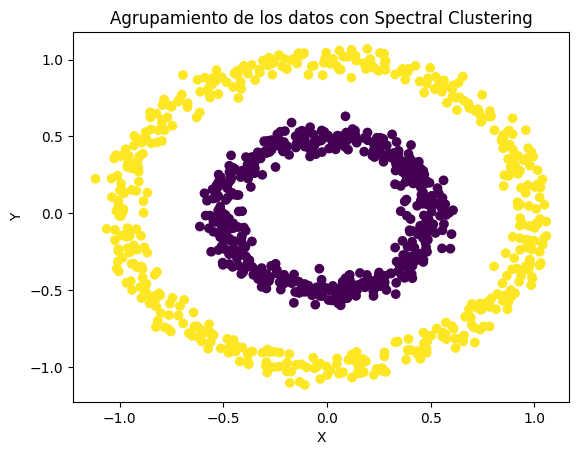

In [16]:
plt.scatter(carac_circulos[:,0], carac_circulos[:,1], c = etiquetas)
plt.title('Agrupamiento de los datos con Spectral Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## 3.2 Implementación del algoritmo Spectral Clustering con la libreria Scikit-learn

Así como Scikit-learn cuenta con el algoritmo K-means, también se puede implementar el algoritmo de clustering espectral de una forma rápida y sencilla. Utilizando los datos generados previamente, haremos pruebas con dicho algoritmo proporcionado por Scikit-learn.

#### 1. Importamos e implementamos Spectral Clustering con Scikit-learn

In [17]:
from sklearn.cluster import SpectralClustering

En esta parte del código instanciamos la clase SpectralClustering, la cual requiere algunos atributos importantes:

- ``n_clusters``: indica la cantidad de clusters (agrupaciones) que se desean obtener.
- ``gamma``: parámetro que se debe ajustar para el cálculo de la matriz de afinidad.
- ``affinity``: método utilizado para calcular la matriz de afinidad $A$.
- ``assign_labels``: método con el cual se asignarán las etiquetas a los datos.

In [18]:
onspectral = SpectralClustering(n_clusters = 2, gamma = 0.1, affinity='rbf', assign_labels='kmeans')
onspectral.fit(carac_circulos)

SpectralClustering(gamma=0.1, n_clusters=2)

In [19]:
labels_spectralclustering = onspectral.labels_

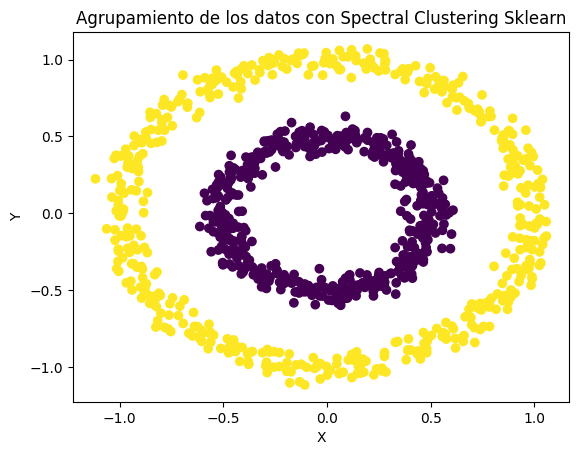

In [20]:
plt.scatter(carac_circulos[:,0], carac_circulos[:,1], c = etiquetas)
plt.title('Agrupamiento de los datos con Spectral Clustering Sklearn')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

En este punto, hemos finalizado con el algoritmo no supervisado Spectral Clustering. En la próxima sección, exploraremos otro algoritmo no supervisado que utiliza un enfoque diferente para generar grupos a partir de un conjunto de datos.

# Reto

#### 1. Probar Spectral Clustering con otros tipos de datos vistos en la sección 1 o creados por usted

In [21]:
# Código